In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

from matplotlib.patches import Rectangle

In [2]:
def F_nu(t_p,nu_p,F_nup,nu_sed):
    '''Calculates a Synchrotron Self-Absorbed Spectrum for given input parameters.
    
    Parameters:
    t_p (days): Time of SSA peak - should be single number
    nu_p (GHz): Frequency of SSA peak - should be single number
    F_nup (mJy): Flux of SSA peak - should be single number
    nu (GHz): Frequencies at which you want the SSA spectrum to be calculated at. Likely an array.
    
    Outputs:
    Fnu (mJy): the flux of the SSA. This is an array with values associated with each value of input array nu.
    '''
    
    m = 0.88 #using stAandard model
    p = 3.0 #using standard model
    a = (2*m)+0.5
    b = (p+5-(6*m))/2
    t=t_p
    Fnu = F_nup*1.582*(t/t_p)**a*(nu_sed/nu_p)**(5/2)*(1-np.exp(-(t/t_p)**(-(a+b))*(nu_sed/nu_p)**(-(p+4)/2)))
    
    return Fnu


def SSA_props(t_p,nu_p,F_nup,D,f=0.5,alpha=1,vw=100,epsilon_b=0.1):
    '''Calculates Synchroton Self-Absorption properties for given input parameters.
    
    Inputs:
    t_p (days): Time of SSA peak - likely a single number
    nu_p (GHz): Frequency of SSA peak - likely a single number
    F_nup (mJy): Flux of SSA peak - likely a single number
    D (Mpc): distance to SN - likely a single number
    f (unitless): filling factor (fraction of emitting region). default is 0.5
    alpha (unitless): ratio charged particles to magnetic field (epsilon_e/epsilon_b). default 1
    v_w (km/s): wind speed. default = 100
    epsilon_b (unitless): fraction of shock energy into B-fields. default = 0.1
    
    Outputs:
    R (cm): radius of material 
    B : magnetic field flux
    E : intermal energy of emitting material
    v (km/s): expansion velocity of material
    M (1d-5 solar masses per year): inferred mass loss rate of progenitor'''
    

    #Radius
    R = 4.0e14*(alpha)**(-1./19.)*(f/0.5)**(-1./19.)*(F_nup)**(9./19.)*(D)**(18./19.)*(nu_p/5.)**(-1)

    # Magnetic field flux
    B = 1.1*(alpha)**(-4/19)*(f/0.5)**(-4/19)*(F_nup)**(-2/19)*(D)**(-4/19)*(nu_p/5)

    #Internal energy of the emitting material
    E = (1/epsilon_b)*((B**2)/(8* 3.142))*((4*3.142*f*R**3)/3.)

    #expansion velocity in km/s
    v = (R/t_p)*1.1574e-10

    #pre-explosion mass-loss in 1e-5 solar mass per year
    M = 1.0*(alpha)**(-8./19.)*(epsilon_b/0.1)*(f/0.5)**(-8./19.)*(F_nup)**(-4./19.)*(D)**(-4./19.)*(nu_p/5.)*(t_p/10.)*(vw/1000.)
    
   

    return R,B,E,v,M


def taufreefree(M,R,nu):
    '''Calculates the free free optical depth for a given set of parameters.
    
    Inputs:
    M (1d-5 solar masses per year): mass loss rate
    R (cm): radius of emitting material
    nu (GHz): Frequencies at which you want tau-ff to be calculated at. Likely an array.
    
    Outputs:
    tau_ff (unitless): the free-free optical depth, calculated at same frequences as input array nu'''

    Z_ave = 5.4  # Average metallicity 1= pure H. 5.4 for a massive star
    miu = 1.9 # mean molecular weight of electrons. 1= pure H  1.9 is for a massive star.
    vw_cgs = 100 * 1e5 # assumed wind velocity in cgs (cm/s). Take this as 1000 * 10^5 for now. (i.e. 1000 km/s in cgs)
    T = 10**4 # temperature of the material absorbing in K.  10^4 is a good starting point. 
        
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units
    
    tau_ff = 2.021e25*M_cgs**2*Z_ave/(miu**2*nu**(2.1)*R**3*vw_cgs**2*T**(1.35))  
    
    return tau_ff

def den(M,R):
    vw_cgs = 100 * 1e5
    M_cgs =  M * 1e-5 * 6.307e+25 #mass loss rate in cgs units 
        #density of the CSM
    density = M_cgs/(4*3.142*R**2*vw_cgs)
    
    return density
#freqs,SED = F_nu(1224.288326 , 8,  0.0272)       
#R2,B2,E2,v2,M2 = SSA_props(1224.288326 , 8,  0.0272,880) 
#tauff=taufreefree(M2,R2,freqs)
#tauff=taufreefree(4,3e14,np.array([2,5,7]))
#print(freqs)
#print(tauff)
#print(R2,B2,E2,v2,M2)

## DEFINE THE PLOTS:

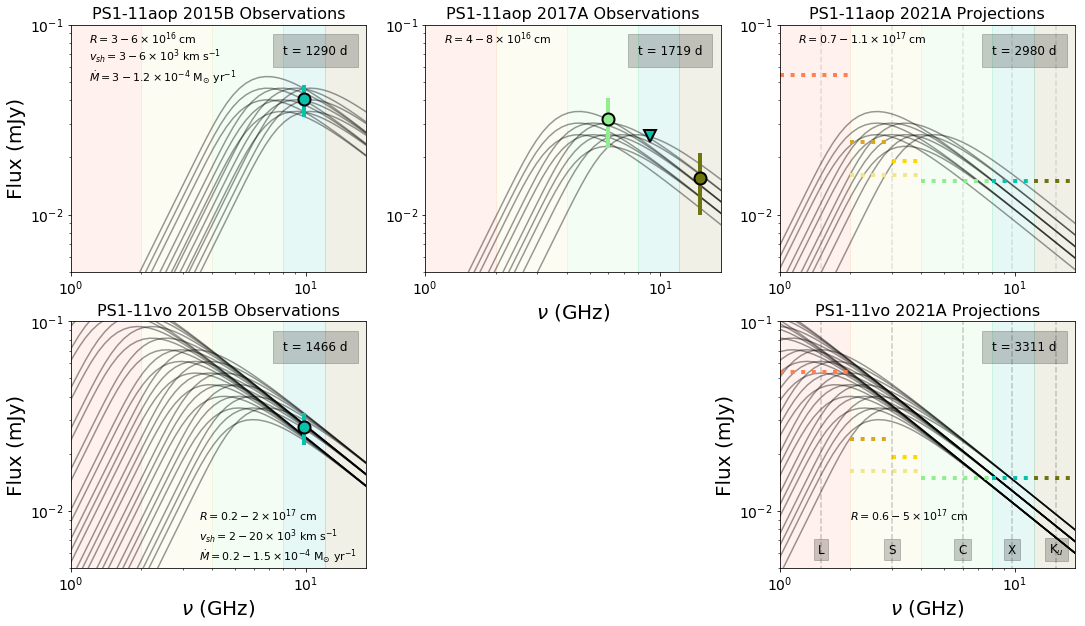

In [92]:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
figure, subplots = plt.subplots(2, 3, figsize=(18,10))
#figure.rcParams.update({'font.size': 10})


####UPPER LEFT:

subplots[0,0].set_xscale('log')
subplots[0,0].set_yscale('log')

file_in = 'PS11aop_grid_e1_allowed.csv'
data_plot = ascii.read(file_in)
D = 1070.1 # distance to SN in Mpc
date_expl = 55736.161 #inferred explosion date
date_obs = 57307.08 # date that radio obs was taken
redshift = 0.218 # redshift of object
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#

index = np.where(data_plot['RuledOut'] == 'False')[0]
data_plot2 = data_plot[index]
index2 = np.where(data_plot2['Radius'] < 7.5e16)[0]
data_plot3 = data_plot2[index2]
index3 = np.where(data_plot3['v_shock'] > 2500.)[0]
data_plot4 = data_plot3[index3]
index4 = np.where(data_plot4['Mdot'] > 0.85)[0]
data_plot5 = data_plot4[index4]
index5 = np.where(data_plot5['Mdot'] < 1.5)[0]
data_plot6 = data_plot5[index5]

Fcalc = data_plot6['F_peak']
nucalc = data_plot6['nu_peak']

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0,0].plot(nu_sed,SSA_FFA_sed,'k',zorder=1,alpha=0.4)
    
#Overplot the data:
subplots[0,0].errorbar(9.77,0.0405,0.0078,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)

r1e = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2e = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3e = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4e = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5e = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[0,0].add_patch(r1e)
subplots[0,0].add_patch(r2e)
subplots[0,0].add_patch(r3e)
subplots[0,0].add_patch(r4e)
subplots[0,0].add_patch(r5e)


#subplots[0,0].xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[0,0].set_ylabel('Flux (mJy)', fontsize=20) 
subplots[0,0].title.set_text('PS1-11aop 2015B Observations')   
subplots[0,0].title.set_fontsize(16) 
subplots[0,0].set_ylim(5e-3,1e-1)
subplots[0,0].set_xlim(1,18)
subplots[0,0].text(8,0.07,'t = 1290 d',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[0,0].text(1.2,0.065,r'$v_{sh} = 3-6\times 10^3$ km s$^{-1}$',fontsize=11)
subplots[0,0].text(1.2,0.05,r'$\.{M} = 3-1.2\times 10^{-4}$ M$_{\odot}$ yr$^{-1}$',fontsize=11)
subplots[0,0].text(1.2,0.08,r'$R = 3-6\times 10^{16}$ cm',fontsize=11)


####UPPER MIDDLE:

subplots[0,1].set_xscale('log')
subplots[0,1].set_yscale('log')


D = 1070.1 # distance to SN in Mpc
date_expl = 55736.161 #inferred explosion date
date_obs = 57829.76513 # date that radio obs was taken
redshift = 0.218 # redshift of object
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
file_in = 'PS11aop_grid_e2_allowed.csv'
data_plot = ascii.read(file_in)

index = np.where(data_plot['RuledOut'] == 'False')[0]
Fcalc = data_plot['F_peak'][index]
nucalc = data_plot['nu_peak'][index]

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0,1].plot(nu_sed,SSA_FFA_sed,'k',zorder=1,alpha=0.4)
    
#Overplot the data:
#plt.plot(3.0,0.405, 'kv', markersize=10)
subplots[0,1].errorbar(6.0,0.0318,0.0095,fmt ='o',color='lightgreen',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)
subplots[0,1].plot(9.02,0.0258, 'v',color='xkcd:turquoise',markersize=12,markeredgecolor='k',markeredgewidth=2)
subplots[0,1].errorbar(14.74,0.0155, 0.0056,fmt='o',color='xkcd:olive',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#, markersize=10)


r1d = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2d = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3d = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4d = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5d = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[0,1].add_patch(r1d)
subplots[0,1].add_patch(r2d)
subplots[0,1].add_patch(r3d)
subplots[0,1].add_patch(r4d)
subplots[0,1].add_patch(r5d)


subplots[0,1].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,1].set_ylabel('Flux (mJy)', fontsize=20) 
subplots[0,1].title.set_text('PS1-11aop 2017A Observations') 
subplots[0,1].title.set_fontsize(16) 
subplots[0,1].set_ylim(5e-3,1e-1)
subplots[0,1].set_xlim(1,18)
subplots[0,1].text(8,0.07,'t = 1719 d',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[0,1].text(1.2,0.08,r'$R = 4-8\times 10^{16}$ cm',fontsize=11)

###UPPER RIGHT HAND SIDE:

subplots[0,2].set_xscale('log')
subplots[0,2].set_yscale('log')

t_p = 2980
D = 1070.14 

file_in = 'Projection_11aop_SSA_d2980.csv'
data_plot = ascii.read(file_in)

Fcalc = data_plot['F_peak']
nucalc = data_plot['nu_peak']

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[0,2].plot(nu_sed,SSA_FFA_sed,'k',zorder=1,alpha=0.4)
    
#Overplot line for detection threshold:
subplots[0,2].plot([1,2],[0.054, 0.054],linestyle=':',linewidth=4,color='coral')
#plt.plot([2,4],[0.018, 0.018],linestyle=':',linewidth=4)
#plt.plot([2,3],[0.027, 0.027],linestyle=':',linewidth=4)
#plt.plot([3,4],[0.0213, 0.0213],linestyle=':',linewidth=4)
subplots[0,2].plot([2,4],[0.0162, 0.0162],linestyle=':',linewidth=4,color='khaki')
subplots[0,2].plot([2,3],[0.024, 0.024],linestyle=':',linewidth=4,color='goldenrod')
subplots[0,2].plot([3,4],[0.0192, 0.0192],linestyle=':',linewidth=4,color='gold')
subplots[0,2].plot([4,8],[0.015, 0.015],linestyle=':',linewidth=4,color='lightgreen')
subplots[0,2].plot([8,12],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:turquoise')
subplots[0,2].plot([12,18],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:olive')


#Overplot central wavelengths for various bands:
subplots[0,2].plot([15,15],[1e-3,1],'k--',alpha=0.1)
subplots[0,2].plot([9.7,9.7],[1e-3,1],'k--',alpha=0.1)
subplots[0,2].plot([6.0,6.0],[1e-3,1],'k--',alpha=0.1)
subplots[0,2].plot([3.0,3.0],[1e-3,1],'k--',alpha=0.1)
subplots[0,2].plot([1.5,1.5],[1e-3,1],'k--',alpha=0.1)

#subplots[0,2].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
#subplots[0,2].set_ylabel('Flux (mJy)', fontsize=20) 
#subplots[0,2].savefig('multiPS11aop.pdf')
subplots[0,2].title.set_text('PS1-11aop 2021A Projections')   
subplots[0,2].title.set_fontsize(16) 
subplots[0,2].set_ylim(5e-3,1e-1)
subplots[0,2].set_xlim(1,18)

#Patch in the background:
r1 = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2 = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3 = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4 = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5 = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[0,2].add_patch(r1)
subplots[0,2].add_patch(r2)
subplots[0,2].add_patch(r3)
subplots[0,2].add_patch(r4)
subplots[0,2].add_patch(r5)
subplots[0,2].text(8,0.07,'t = 2980 d',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[0,2].text(1.2,0.08,r'$R = 0.7-1.1\times 10^{17}$ cm',fontsize=11)

########LOWER LEFT#################
subplots[1,0].set_xscale('log')
subplots[1,0].set_yscale('log')

date_expl = 55670.403 #inferred explosion date
date_obs = 57306.5258# date that radio obs was taken
redshift = 0.116 # redshift of object
t_p = (date_obs - date_expl)/(1+redshift) # time of observation in days #1261.509031#
D = 543.4
file_in = 'PS11vo_grid_e1_allowed.csv'
data_plot = ascii.read(file_in)

index = np.where(data_plot['RuledOut'] == 'False')[0]
data_plot2 = data_plot[index]
index2 = np.where(data_plot2['v_shock'] < 20000.)[0]
data_plot3 = data_plot2[index2]
index3 = np.where(data_plot3['v_shock'] > 2000.)[0]
data_plot4 = data_plot3[index3]

Fcalc = data_plot4['F_peak']
nucalc = data_plot4['nu_peak']

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)




###Cycle over the SEDs to show######
for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1,0].plot(nu_sed,SSA_FFA_sed,'k',zorder=1,alpha=0.4)
    
#Overplot the data:
subplots[1,0].errorbar(9.77,0.0277,0.0053,fmt ='o',color='xkcd:turquoise',markersize=12,elinewidth=4,markeredgecolor='k',markeredgewidth=2)#'ro', markersize=10)


r1c = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2c = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3c = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4c = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5c = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1,0].add_patch(r1c)
subplots[1,0].add_patch(r2c)
subplots[1,0].add_patch(r3c)
subplots[1,0].add_patch(r4c)
subplots[1,0].add_patch(r5c)


subplots[1,0].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[1,0].set_ylabel('Flux (mJy)', fontsize=20) 
subplots[1,0].title.set_text('PS1-11vo 2015B Observations') 
subplots[1,0].title.set_fontsize(16) 
subplots[1,0].set_ylim(5e-3,1e-1)
subplots[1,0].set_xlim(1,18)
subplots[1,0].text(8,0.07,'t = 1466 d',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[1,0].text(3.5,0.009,r'$R = 0.2-2\times 10^{17}$ cm',fontsize=11)
subplots[1,0].text(3.5,0.007,r'$v_{sh} = 2-20\times 10^3$ km s$^{-1}$',fontsize=11)
subplots[1,0].text(3.5,0.0055,r'$\.{M} = 0.2-1.5\times 10^{-4}$ M$_{\odot}$ yr$^{-1}$',fontsize=11)


########LOWER MIDDLE#################

subplots[1,1].axis("off")



#####LOWER RIGHT######################

subplots[1,2].set_xscale('log')
subplots[1,2].set_yscale('log')

t_p = 3311
D = 543.4

file_in = 'Projection_11vo_SSA_d3311.csv'
data_plot = ascii.read(file_in)

Fcalc = data_plot['F_peak']
nucalc = data_plot['nu_peak']

nu_sed=np.logspace(np.log10(0.1),np.log10(50),num=100)

for i in range(len(Fcalc)):
    #calculate SSA
    SSA_sed = F_nu(t_p,nucalc[i],Fcalc[i],nu_sed)
    
    #calculate Mass loss rate, Radius, velocity, etc.
    R,B,E,v,M = SSA_props(t_p,nucalc[i],Fcalc[i],D)

    #calculate tau_ff
    tauff = taufreefree(M,R,nu_sed)
        
    #Correct SED for FFA:
    SSA_FFA_sed = SSA_sed*np.exp(-tauff)
    
    #Plot it:
    subplots[1,2].plot(nu_sed,SSA_FFA_sed,'k',zorder=1,alpha=0.4)
    
#Overplot line for detection threshold:
subplots[1,2].plot([1,2],[0.054, 0.054],linestyle=':',linewidth=4,color='coral')
#plt.plot([2,4],[0.018, 0.018],linestyle=':',linewidth=4)
#plt.plot([2,3],[0.027, 0.027],linestyle=':',linewidth=4)
#plt.plot([3,4],[0.0213, 0.0213],linestyle=':',linewidth=4)
subplots[1,2].plot([2,4],[0.0162, 0.0162],linestyle=':',linewidth=4,color='khaki')
subplots[1,2].plot([2,3],[0.024, 0.024],linestyle=':',linewidth=4,color='goldenrod')
subplots[1,2].plot([3,4],[0.0192, 0.0192],linestyle=':',linewidth=4,color='gold')
subplots[1,2].plot([4,8],[0.015, 0.015],linestyle=':',linewidth=4,color='lightgreen')
subplots[1,2].plot([8,12],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:turquoise')
subplots[1,2].plot([12,18],[0.015, 0.015],linestyle=':',linewidth=4,color='xkcd:olive')

#Overplot central wavelengths for various bands:
subplots[1,2].plot([15,15],[1e-3,1],'k--',alpha=0.2)
subplots[1,2].plot([9.7,9.7],[1e-3,1],'k--',alpha=0.2)
subplots[1,2].plot([6.0,6.0],[1e-3,1],'k--',alpha=0.2)
subplots[1,2].plot([3.0,3.0],[1e-3,1],'k--',alpha=0.2)
subplots[1,2].plot([1.5,1.5],[1e-3,1],'k--',alpha=0.2)

r1b = Rectangle((1,5e-3),1,0.095,color='coral',alpha=0.1,zorder=1)
r2b = Rectangle((2,5e-3),2,0.095,color='khaki',alpha=0.1,zorder=1)
r3b = Rectangle((4,5e-3),4,0.095,color='lightgreen',alpha=0.1,zorder=1)
r4b = Rectangle((8,5e-3),4,0.095,color='xkcd:turquoise',alpha=0.1,zorder=1)
r5b = Rectangle((12,5e-3),6,0.095,color='xkcd:olive',alpha=0.1,zorder=1)
subplots[1,2].add_patch(r1b)
subplots[1,2].add_patch(r2b)
subplots[1,2].add_patch(r3b)
subplots[1,2].add_patch(r4b)
subplots[1,2].add_patch(r5b)

subplots[1,2].set_xlabel(r'$\nu$ (GHz)', fontsize=20) #Log$_{10}$ t$_{rest}$(days)($\u03BD$ /5 GHz)', fontsize=14)
subplots[1,2].set_ylabel('Flux (mJy)', fontsize=20) 
subplots[1,2].title.set_text('PS1-11vo 2021A Projections')   
subplots[1,2].title.set_fontsize(16)   
subplots[1,2].set_ylim(5e-3,1e-1)
subplots[1,2].set_xlim(1,18)
subplots[1,2].text(8,0.07,'t = 3311 d',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 10})
subplots[1,2].text(2,0.009,r'$R = 0.6-5\times 10^{17}$ cm',fontsize=11)

subplots[1,2].text(1.45,0.006,'L',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[1,2].text(2.9,0.006,'S',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[1,2].text(5.75,0.006,'C',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[1,2].text(9.3,0.006,'X',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})
subplots[1,2].text(14,0.006,r'K$_u$',fontsize=12,bbox={'facecolor': 'k', 'alpha': 0.2, 'pad': 4})

#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#plt.tight_layout()
plt.savefig('VLA2021A_SED_Projections.pdf')
plt.show()